## Mathematical optimization series

# Part  7: Coordinate descent

In this post we discuss *coordinate descent*, sometimes referred to as *alternating descent*.  At a high level the concept is simple: thus far we have discussed ways of minimizing a cost function $g\left(w_1,w_2,...,w_N\right)$ with respect to all of its parameters *simultaneously*.  With coordinate descent we attempt to minimize such a function with respect to one weight at a time - or one subset of weights at a time - keeping all the others fixed.

Coordinate descent is a simple heuristic, but a powerful one.  Indeed in its simplest form coordinate descent is perhaps the first optimization algorithm one would think of after learning about the [first order condition for optimality](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Calculus/Part_13_unconstrained_optimality_conditions.html) provided by calculus.  However with the addition of the hallmark tools of mathematical optimization - gradient descent and Newton's method - this simple idea can be extended in a variety of useful ways that are extremely popular in machine learning.  Coordinate descent (and variations on it) is a widely used optimization method for a number of machine learning problems including boosting methods for nonlinear supervised learning, K-Means clustering, nonnegative matrix factorization problems, recommender systems and general matrix factorization problems.  

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import math_optimization_library as optlib
import autograd.numpy as np
import copy

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# 1. Coordinate descent

So far we have examined ways of minimizing a cost function $g\left(w_1,w_2,...,w_N\right)$ with respect to all of its input variables *simultaneously* which - if implemented correctly - can provide us with the minimum defining weights for $g$.  When implemented correctly these methods produce a series of simultaneous weight updates $\left(w_1^{k}\,,w_2^{k}\,...\,,w_N^{k}\right)$ which converge to the global minimum of a function i.e., that solve

\begin{equation}
\underset{w_1,w_2,...,w_N}{\text{minimize}}\,\,\,g\left(w_1,w_2,w_3,...,w_N\right).
\end{equation}

Denoting the weights that (at least approximately) solve this problem $\left(w_1^{\star}\,,w_2^{\star}\,,...,w_N^{\star}\right)$ note that we may write them equivalently as

\begin{equation}
w_1^{\star}\,,w_2^{\star}\,,...,w_N^{\star} = \underset{w_1\,,w_2\,,...,w_N}{\text{argmin}}\,\,\,g\left(w_1,w_2,...,w_N\right).
\end{equation}

Coordinate descent is takes a more heuristic approach to solving the minimization problem - instead of minimizing over all weights simultaneously, we do so one weight at a time.  

Beginning at an initial point $\left(w_1^{0}\,,w_2^{0}\,...\,,w_N^{0}\right)$ we first minimize $g$ with respect to $w_1$ alone, keeping all other weights fixed at their initial values.  This gives us our first update $w_1^1$ which is the minimum of $g$ along $w_1$ alone

\begin{equation}
\underset{w_1}{\text{minimize}}\,\,\,g\left(w_1^{\,},w_2^0,w_3^0,...,w_N^0\right).
\end{equation}

The minimizer (or approximate minimizer depending on how the minimization is performed) we call $w_1^1$, and since this is the argument of the minimizer we can express it equivalently as 

\begin{equation}
w_1^{1} = \underset{w_1}{\text{argmin}}\,\,\,g\left(w_1^{\,},w_2^0,w_3^0,...,w_N^0\right).
\end{equation}

Replacing the initial value of $w_1$ with its update $w_1^0 \longleftarrow w_1^1$ we then cycle through the inputs - updating $w_2$ next in precisely the same fashion, that is we solve

\begin{equation}
\underset{w_2}{\text{minimize}}\,\,\,g\left(w_1^1,w_2^{\,},w_3^0,...,w_N^0\right).
\end{equation}

whose argument here we call $w_2^1$.  Again we can express this equivalently as

\begin{equation}
w_2^{1} = \underset{w_2}{\text{argmin}}\,\,\,g\left(w_1^1,w_2^{\,},w_3^0,...,w_N^0\right).
\end{equation}

And we keep going - updating the $n^{th}$ weight by minimizing with respect to $w_n$ alone (fixing all other weights at their current values), giving the update

\begin{equation}
w_n^{1} = \underset{w_n}{\text{argmin}}\,\,\,g\left(w_1^1,w_2^{1},w_3^1,...,w_{n-1}^1,w_{n \phantom{1}}^{\phantom{1}},w_{n+1}^{0},...,w_N^0\right).
\end{equation}

We continue these updates reaching the final weight $w_N$, which we update accordingly

\begin{equation}
w_N^{1} = \underset{w_N}{\text{argmin}}\,\,\,g\left(w_1^1,w_2^{1},w_3^1,...,w_{N-1}^{1},w_N^{\,}\right).
\end{equation}

With this update we have finished one complete sweep through the weight vector, and our fully updated weights are now $\mathbf{w}^1 = \begin{bmatrix} w_1^1 \\ w_2^1 \\ \vdots \\ w_N^1  \end{bmatrix}$.  This becomes the initialization for our second sweep through the weights, updating them precisely as we have seen above (only now our initialization is $\mathbf{w}^1$).  This second sweep yeilds an update vector $\mathbf{w}^2$ consisting of the second sweep updates, and so forth.

Depending on the problem several complete sweeps through the weights are performed in order to reach a minimum of $g$.  Hence we can write our individual weight update step in general: at the $k^{th}$ sweep we update $w_n$ as

\begin{equation}
w_n^{k} = \underset{w_n}{\text{argmin}}\,\,\,g\left(w_1^{k},w_2^{k},w_3^{k},...,w_{n-1}^{k},w_{n\vphantom{+1}}^{\,},w_{n+1}^{k-1},...,w_N^{k-1}\right).
\end{equation}

There are a number of ways of solving each of these single dimension minimization problems - ranging from (the rare case when) solving the first order equation, gradient descent, and Newton's method.

Furthermore there are a number of variations on this basic coordinate descent theme that are used in practice, including: updating coordinates in a random order, updating blocks of coordinates at-a-time, and picking only the coordinate that provides maximum decrease in the cost function.

## 1.2  General coordinate descent pseudo-code

The general pseudo-code for coordinate descent is given below.  In the remainder of this Section we will go through a range of examples employing coordinate descent where the individual update step is solved in a variety of ways.

Note that the initial point often chosen in practice for this algorithm $\mathbf{w}^0$ is simply the zero vector, but a random selection is also commonplace.  Also note that as with other optimization methods one can choose from a variety of stopping conditions for coordinate descent.  In the pseudo-code we use the 'maximum iterations reached' stopping condition but others - like halting when the method stops providing descent above a certain tolerance - are often used in practice as well.  The same holds for what one desires returned from the method - here we show the return of the best set of weights (in terms of those providing the lowest evaluation of the input cost function), but one can also e.g., record the weights at each inner / outer loop and return an entire weight history for analysis.

### Coordinate descent algorithm

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>Input:</strong> cost function $g\left(\mathbf{w}\right)$, initial point $\mathbf{w}^0$, maximum number of steps $K$, set $\mathbf{w}_{\text{best}} = \mathbf{w}^0$ <br>


<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,k = 1...K$<br>


<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $n=1...N$ <br>


<strong>4:
</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $w_n^{k} = \underset{w_n}{\text{argmin}}\,\,\,g\left(w_1^{k},w_2^{k},w_3^{k},...,w_{n-1}^{k},{w}_{n \vphantom{+1}}^{\,},w_{n+1}^{k-1},...,w_N^{k-1}\right)$<br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\,$ update  $w_n^{k-1} \longleftarrow w_n^{k}$ <br>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> end for</code> <br>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> if </code> $g\left(\mathbf{w}^k\right) < g\left(\mathbf{w}_{\text{best}}\right)$ <code>then</code>  <br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\,$ update  $\mathbf{w}_{\text{best}} \longleftarrow \mathbf{w}^k$ <br>

<strong>9:</strong>&nbsp;&nbsp; <code>end for</code><br>

<strong>10:</strong>&nbsp;&nbsp; <strong>output:</strong> $\mathbf{w}^{K}$ <br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>


## 1.3 Harnessing the first order condition directly

The first order condition for optimality is a powerful calculus-based way of characterizing the minima of a function.  Remember that [the first order condition](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Calculus/Part_13_unconstrained_optimality_conditions.html) tells us that - for a given cost function $g\left(\mathbf{w}\right)$ taking in $N$ dimensional input - that the stationary points of this function are those satisfying the system of equations

\begin{equation}
\nabla g\left(\mathbf{v}\right)=\mathbf{0}_{N\times1}
\end{equation}

or written out one equation at-a-time as

\begin{equation}
\begin{array}
\
\frac{\partial}{\partial w_{1}}g(\mathbf{v})=0\\
\frac{\partial}{\partial w_{2}}g(\mathbf{v})=0\\
\,\,\,\,\,\,\,\,\,\,\vdots \\
\frac{\partial}{\partial w_{N}}g(\mathbf{v})=0.
\end{array}
\end{equation}

However rarely can we use it in practice to actually solve the first order systems of equations simulatneously 'by hand'.   Even solving a system of $N$ simultaneous linear equations 'by hand' is infeasible - we need an algorithm to make such computations in a timely manner (coordinate descent is actually one such algorithm for solving certain common types of systems of linear equations).

Solving even just the $n^{th}$ equation in this system for $w_n$ in closed form (algebraically) - keeping all other weights fixed - is often problematic.  However one important exception where this can be done is the general convex quadratic function

\begin{equation}
g(\mathbf{w}) = a + \mathbf{b}^T \mathbf{w} + \mathbf{w}^T \mathbf{C} \mathbf{w}
\end{equation}

since fixing every variable but $w_n$ reduces the above to a single-input quadratic function whose minimum can easily be computed (we will do this below).  This fact is important in machine learning because the Least Squares cost function for regression is itself a convex quadratic function whenever we use e.g., linear regression, regression with kernels, and regression with trees (e.g., gradient boosting).

Hence for a quadratic function we can indeed compute the general update step

\begin{equation}
w_n^{k} = \underset{w_n}{\text{argmin}}\,\,\,g\left(w_1^{k},w_2^{k},w_3^{k},...,w_{n-1}^{k},w_{n\vphantom{+1}}^{\,},w_{n+1}^{k-1},...,w_N^{k-1}\right).
\end{equation}

by directly solving the equation $n^{th}$ first order equation (keeping all other weights fixed at their most recent respective values) as

\begin{equation}
\frac{\partial}{\partial w_{n}}g\left(w_1^{k},w_2^{k},w_3^{k},...,w_{n-1}^{k},w_{n\vphantom{+1}}^{\,},w_{n+1}^{k-1},...,w_N^{k-1}\right)=0.
\end{equation}

Lets see how this is done.

#### <span style="color:#a50e3e;">Example 1:</span>  Minimizing a convex quadratic via coordinate descent

In this example we develop the coordinate descent for minimizing the convex quadratic function

\begin{equation}
g\left(\mathbf{w}\right)=a + \mathbf{b}^{T}\mathbf{w} + \mathbf{w}^{T}\mathbf{C}\mathbf{w}
\end{equation}

In practice we almost never care about finding the minimum of a function that dips down to negative infinity, so in keeping with this we will assume that the quadratic is convex (this means that the matrix $\mathbf{C}$ is both symmetric and has all nonnegative eigenvalues - see [our post on general quadratic functions](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Calculus/Part_10_quadratic_functions.html) if any of this terminology is unfamiliar).

For example - the quadratic with parameters

\begin{array}
\
a = 0 \\
\mathbf{b} = \begin{bmatrix}10 \\ 10 \end{bmatrix} \\
\mathbf{C} = \begin{bmatrix} \,\,\,\,\,5 \,\,\, -3 \\ -3 \,\,\,\,\,\,\,\, 6 \end{bmatrix}
\end{array}

which is plotted by the Python cell below is such a convex quadratic.  In the left panel we show the surface plot of this function, while on the right we show its contour plot (here the contours are colored dark to light as the function gets smaller).  

<IPython.core.display.Javascript object>


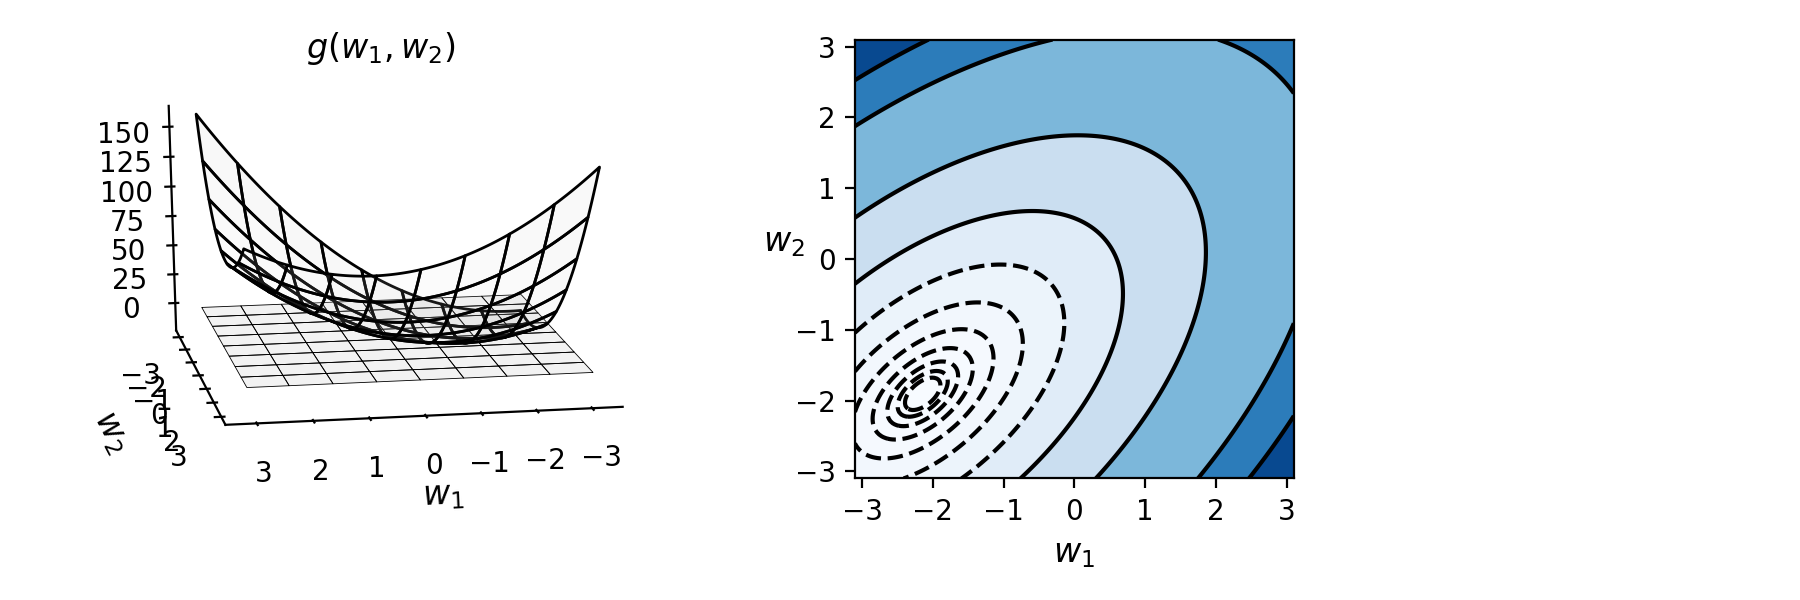

In [2]:
# define constants for a N=2 input quadratic
a = 0
b = 10*np.ones((2,1))
C = np.array([[5,-3],[-3,6]])

# a quadratic function defined using the constants above
g = lambda w: (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

# create an instance of the visualizer and plot the function above
demo = optlib.coord_descent_plotter.Visualizer();
demo.draw_setup(g,num_contours = 30,view = [20,80])

In Example 7 in [our post on the first order condition](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Calculus/Part_13_unconstrained_optimality_conditions.html) we saw that the first order system for a general quadratic is given as

\begin{equation}
\nabla g(\mathbf{w}) = 2\mathbf{C}\mathbf{w} + \mathbf{b} = \mathbf{0}_{N\times 1}
\end{equation}

or if we write out the system equation-wise

\begin{equation}
\begin{array}
\
\frac{\partial}{\partial w_{1}}g(\mathbf{w})= 2\left(c_{11}w_1 + c_{12}w_2 + c_{13}w_3 +  \cdots + c_{1N}w_N\right) + b_1 = 0\\
\frac{\partial}{\partial w_{2}}g(\mathbf{w})=2\left(c_{21}w_1 + c_{22}w_2 + c_{23}w_3 + \cdots + c_{2N}w_N\right) + b_2 = 0\\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\vdots \\
\frac{\partial}{\partial w_{N}}g(\mathbf{w})=2\left(c_{N1}w_1 + c_{N2}w_2 + c_{N3}w_3 +  \cdots + c_{NN}w_N\right) + b_N = 0
\end{array}
\end{equation}

Note that this system is linear in its weights.  

Instead of trying to solve this system *simultaneously* we can try to solve it *sequentially* via coordinate descent.  To begin we initialize at a point

\begin{equation}
\mathbf{w}^0 = \begin{bmatrix} w_1^0 \\ w_2^0 \\ \vdots \\ w_N^0 \end{bmatrix}.
\end{equation}

This point could be chosen at random or set to zero $\mathbf{w}^0 = \mathbf{0}_{N\times 1}$.  We then begin our weight updates at the top equation $\frac{\partial}{\partial w_{1}}g(\mathbf{w}) = 0$ - solving this for $w_1$ along with all over weights fixed at $w_j = w_j^0$.  We work our way down the list of single-variable equations solving each until we reach the final equation $\frac{\partial}{\partial w_{N}}g(\mathbf{w})= 0$. 

Examining the individual first order equations of a quadratic function - notice how each individual equation $\frac{\partial}{\partial w_{n}}g(\mathbf{w})= 0$ can be solved for in closed form when keeping all other variables fixed. 

For example, we solve for $w_1$ in the first equation by simply re-arranging terms as

\begin{equation}
w_1^1 = -\frac{c_{12}^{\,}w_2^0 +c_{13}^{\,}w_3^0 +  \cdots + c_{1N}^{\,}w_N^0 + \frac{1}{2}b_1^{\,}}{c_{11} }.
\end{equation}

Note here again - all other variables are fixed to their initial values, and we have denoted the solution $w_1^1$ since we now overwrite our initial value for $w_1$ with this value $w_1^0 \longleftarrow w_1^1$.

With this value in hand we can then solve the second equation $\frac{\partial}{\partial w_{2}}g(\mathbf{w}) = 0$.  Fixing every variable but $w_2$ to its current value we can then - just as we did with the first equation - solve for an update $w_2^1$ by rearranging

\begin{equation}
w_2^1 = -\frac{c_{21}^{\,}w_1^1 + c_{23}^{\,}w_3^0 + \cdots + c_{2N}^{\,}w_N^0 + \frac{1}{2}b_2^{\,}}{c_{22} }
\end{equation}

Updating our second value $w_2^0 \longleftarrow w_2^1$ we can likewise solve the third equation to  update the third variable $w_3^1$ by similarly rearranging it, which gives

\begin{equation}
w_3^1 = -\frac{c_{31}^{\,}w_1^1 + c_{32}^{\,}w_2^1 + \cdots + c_{3N}^{\,}w_N^0 + \frac{1}{2}b_3^{\,}}{c_{33} }
\end{equation}

Updating the third value $w_3^0 \longleftarrow w_3^1$ we can continue this for the general $n^{th}$ equation update as well

\begin{equation}
w_n^1 = -\frac{c_{n1}^{\,}w_1^1 + c_{n2}^{\,}w_2^1 + \cdots + c_{nN}^{\,}w_N^0 + \frac{1}{2}b_n^{\,}}{c_{nn} }
\end{equation}

until solving all $N$ equations at which time we have the updated point 

\begin{equation}
\mathbf{w}^1 = \begin{bmatrix} w_1^1 \\ w_2^1 \\ \vdots \\ w_N^1 \end{bmatrix}
\end{equation}

With the final value updated we have now completed one sweep of coordinate descent.  If need be we can then repeat these computations - taking another sweep through the first order equations - using $\mathbf{w}^1$ as the initial values for our weights - to further refine our solution.

In the next Python cell we implement this update scheme in Python in the function ``coordinate_descent_for_quadratic``.  This Python function takes in the constants of a quadratic ($a$, $\mathbf{b}$, and $\mathbf{C}$) and outputs a weight history at each individual weight update.  This is done so that we can visualize the resulting cost function decrease in a variety of ways.  In practice one need not record the weights at each weight update but e.g., the weights after each sweep through the coordinates, or the weight corresponding to the lowest cost function value attained thus far.

Note - in terms of practical engineering - that we have included a stopping condition based a pre-set number of outer loops of the method (i.e., the number of total sweeps through all the variables) and a stopping condition basd on the change in cost function value from (outer) iteration to iteration.  So the method stops when we either reach a maximum number $K$ of pre-set iterations or when the method stops providing descent in the cost function beyond a certain defined tolerance.

In [131]:
def coordinate_descent_for_quadratic(a,b,C,max_its):
    '''
    Alternating descent wrapper for general quadratic function. Here
    
    a - a constant
    b - an Nx1 vector
    C - an NxN matrix (symmetric and all nonnegative eigenvalues)
    '''
        
    # settings 
    its = max_its                      # max its to run
    tol = 10**(-8)                     # tolerance to between sweeps to stop (optional)
    N = len(b)                         # length of weights
    w = np.zeros((N,1))                # initialization
    w = np.random.randn(N,1)
    w_history = [copy.deepcopy(w)]     # record each weight for plotting
    
    # outer loop - each is a sweep through every variable once
    i = 0
    g_change = np.inf; gval1 = g(w);
    while i < its and g_change > tol:
        # inner loop - each is a single variable update
        for n in range(N):
            w[n] = -(np.dot(C[n,:],w) - C[n,n]*w[n] + 0.5*b[n])/float(C[n,n])
            
            # record weights at each step for kicks
            w_history.append(copy.deepcopy(w))
            
        # update counter and tol measure
        gval2 = copy.deepcopy(gval1)
        gval1 = g(w)
        g_change = abs(gval1 - gval2)/float(np.size(w))
        i+=1
    return w_history

Below we run the coordinate descent code to minimize the $N = 2$ dimensional input quadratic plotted by the previous Python cell.

In [100]:
# define constants for a N=2 input quadratic
a = 0
b = 10*np.ones((2,1))
C = np.array([[5,-3],[-3,6]])

# run your alternating descent code
w_history = coordinate_descent_for_quadratic(a,b,C,max_its = 5)

Given the form of the cost function and our history of recorded weights we can plot the value of the cost function at each step of the method to analyze the method's behavior.  We do this in the Python cell below.  Notice that the horizontal axes of this cost function plot is incremented in the number of *outer loops* of the coordinate descent method.

<IPython.core.display.Javascript object>


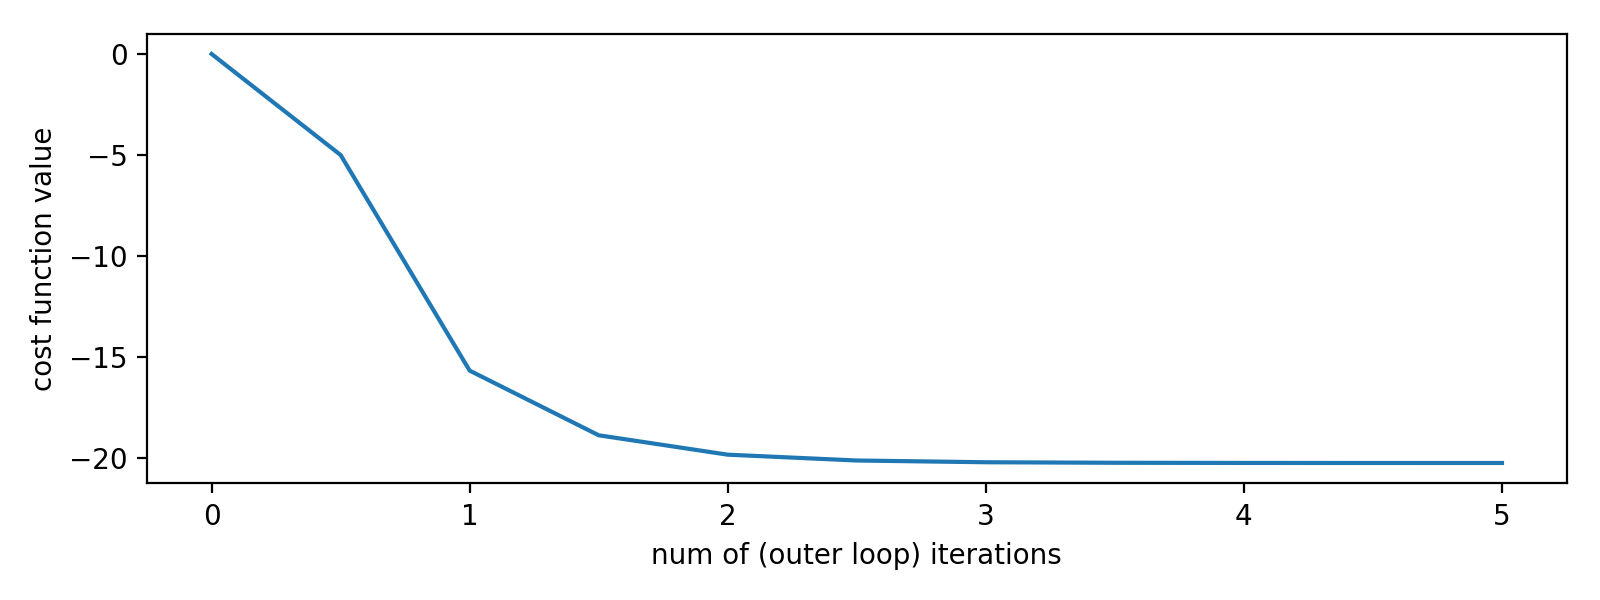

In [101]:
# define the quadratic
g = lambda w: (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

# plot resulting cost function history based on w_history
demo = optlib.coord_descent_plotter.Visualizer();
demo.plot_coord_descent_cost_history(g,w_history)

We can see that it takes just a few sweeps through the variables for the method to converge for this example.  This rapid convergence is quite characteristic of coordinate descent.

Since $N = 2$ here we can also visualize the path taken by the method by plotting the weight history on top of the contours of the function itself.  We do this in the next Python cell.  Here each individual update is plotted and colored from green (when the method begins) to red (as the method begins to halt).

<IPython.core.display.Javascript object>


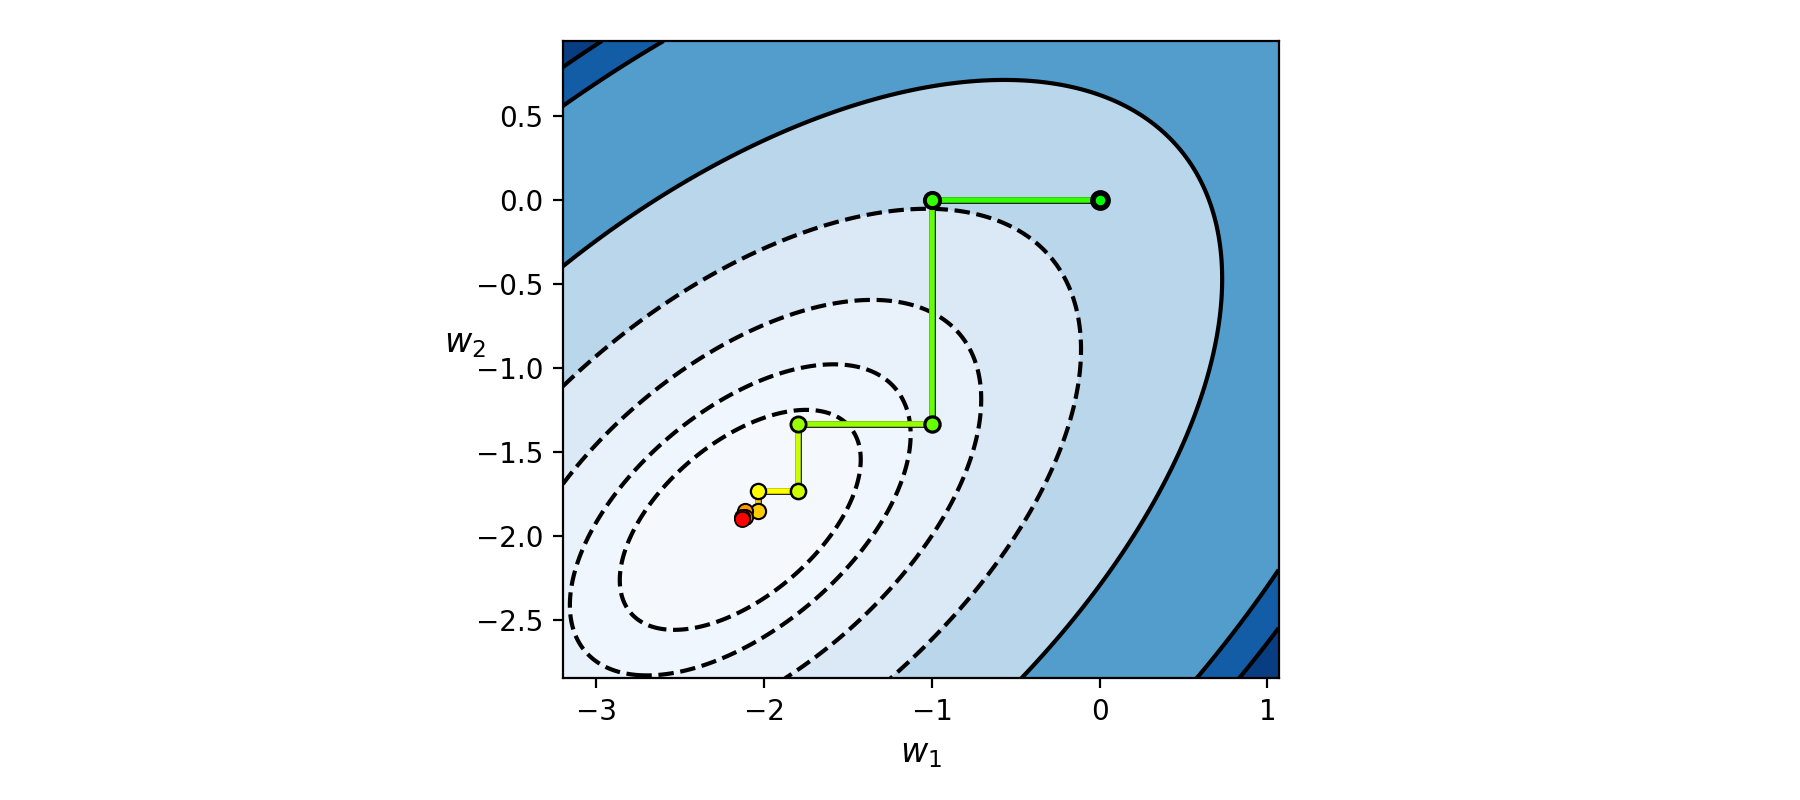

In [6]:
# plot the path taken by alternating descent by plotting each weight from your history
demo.show_path(g,w_history,num_contours = 20)

Next we illustrate the same implementation of coordinate descent applied to minimize a higher dimensional convex quadratic function.  In the next Python cell we define a random convex quadratic in 100 dimensions and then minimize it using ``coordinate_descent_for_quadratic``.  We plot the cost function decrease plot afterwards so we can analyze the results.

In [202]:
# define a random convex quadratic 
dim = 100
C = np.random.randn(dim,dim)
C = np.dot(C,C.T)

# initialize b vec to random, and a = 0 (since it has no impact on the minimum)
b = np.random.rand(dim,1)
a = 0

In [204]:
# run your alternating descent code
max_its = 100
w_history = coordinate_descent_for_quadratic(a,b,C,max_its)

<IPython.core.display.Javascript object>


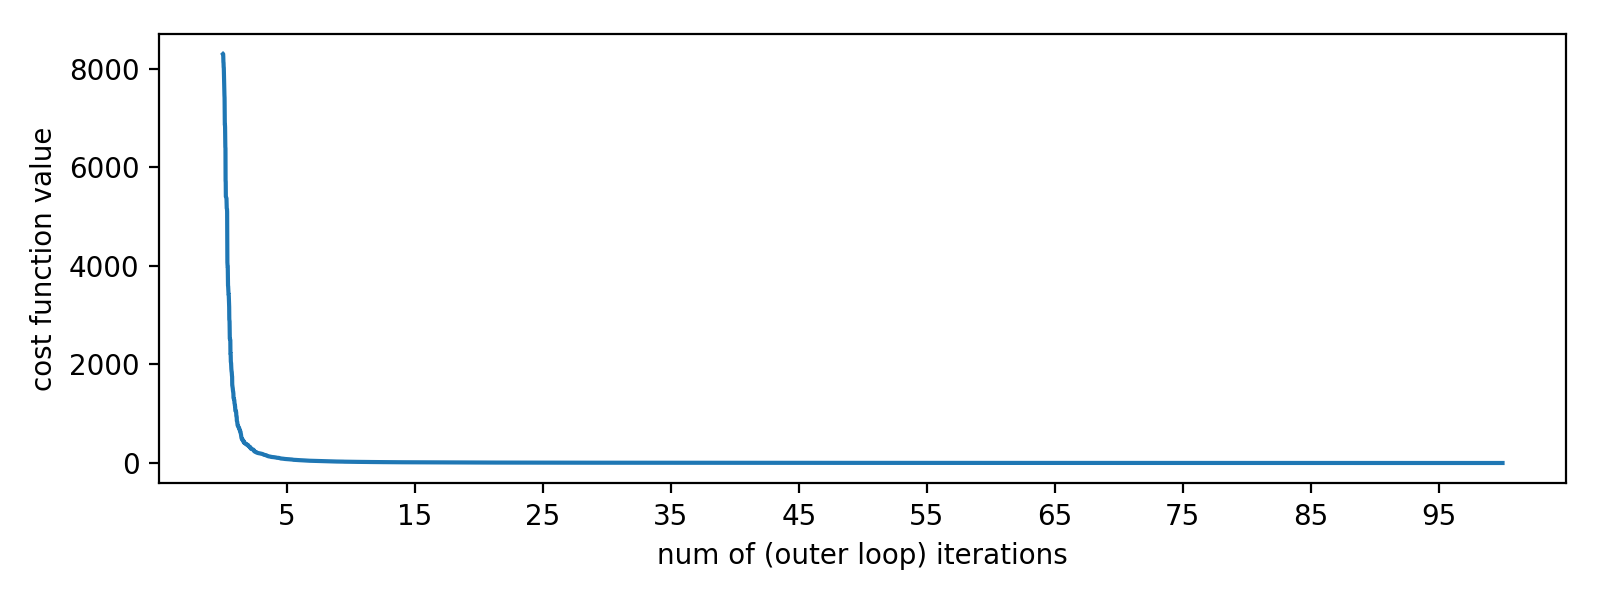

In [205]:
# define the quadratic
g = lambda w: (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

# plot resulting cost function history based on w_history
demo = optlib.coord_descent_plotter.Visualizer();
demo.plot_coord_descent_cost_history(g,w_history)

Here we take a greater number of outer iterations of coordinate descent to reach the global minimum of this random higher dimensional convex quadratic, but we are still able to reach a point close to the minimum in just a few steps. 

#### <span style="color:#a50e3e;">Example 2:</span>  Solving systems of equations

Note how in the previous example the first order system turned out to be *linear*.  More specifically, we ended up using coordinate descent to solve the linear system (re-arranging equation (5)) 

\begin{equation}
\mathbf{C}\mathbf{w} = - \frac{1}{2}\mathbf{b}.
\end{equation}

Here square symmetric $N \times N$ matrix $\mathbf{C}$ and the $N\times 1$ vector $\mathbf{b}$ came from an associated quadratic (and since that quadratic is assumed convex, $\mathbf{C}$ must be *positive semi-definite*, i.e., it must  have all nonnegative eigenvalues).  However, divorced from the concept of a quadratic we can think of coordinate descent in a broader context - as a method for solving more general linear systems of equations where the matrix $\mathbf{C}$ is positive semi-definite.  

Thus we can re-interpret the experiments performed in the previous example in just this way - as examples of coordinate descent applied to solving square linear systems of equations where the matrix $\mathbf{C}$ is positive semi-definite.

## 1.4  Using first or second order updates along each input dimension

More often than not we cannot solve for the indiviudal weight update

\begin{equation}
w_n^{k} = \underset{w_n}{\text{argmin}}\,\,\,g\left(w_1^{k},w_2^{k},w_3^{k},...,w_{n-1}^{k},w_{n\vphantom{+1}}^{\,},w_{n+1}^{k-1},...,w_N^{k-1}\right).
\end{equation}

by solving the corresponding first order equation.  Therefore we approximate the above by either applying gradient descent steps or Newton's method steps along each individual input weight.

Often in practice only a single gradient descent or Newton step is made in each direction - a rough approximation to the true minimum desired - but this is done for effeciency's sake.   Our goal is not to minimize $g$ a in just a single variable but the entire set of weights, and thus in terms of computation applying more frequent updates to all weights as opposed to focusing on convergence in each individual input is often a more effecient choice practically speaking.

#### <span style="color:#a50e3e;">Example 3:</span>  Minimizing Least Squares

The Least Squares cost function for linear regression is a convex quadratic function (as we saw in Example 4 of our post on [linear regression](https://jermwatt.github.io/mlrefined/blog_posts/Linear_Supervised_Learning/Part_1_Linear_regression.html)), thus we can directly apply our coordinate descent code for minimizing a quadratic function to solve the linear regression problem by simply translating the Least Squares cost into the standard quadratic form.  Given the form of the matrix $\mathbf{C}$ in this instance this approach is limited to use when the dimension of the input $N$ is less than around ten thousand, at which point the matrix cannot be stored or computed with effectively.  Otherwise it is better to apply coordinate descent algorithm directly to the explicit form of the Least Sqaures cost function so we avoid dealing with such large matrices, which we do below.  While expressed in different  more cost-saving terms, these updates will of course take on the same numerical values as those of the quadratic form.

For a dataset of $P$ points $\left(\mathbf{x}_{1},y_{1}\right),\,\left(\mathbf{x}_{2},y_{2}\right),\,...,\,\left(\mathbf{x}_{P},y_{P}\right)$ we re-annotate using the compact notation

\begin{equation}
\mathbf{w} \longleftarrow \left[\begin{array}{c}
w_{0}\\
\mathbf{w}
\end{array}\right]
\,\,\,\,\text{and}\,\,\,\,\,
\mathbf{x}_{p}\longleftarrow\left[\begin{array}{c}
1\\
\mathbf{x}_{p}.
\end{array}\right]
\end{equation}

and write our Least Squares cost function as

\begin{equation}
\,g\left(\mathbf{w}\right)=\sum_{p=1}^{P}\left(\mathbf{x}_{p}^{T}\mathbf{w}_{\,}-y_{p}^{\,}\right)^{2}.
\end{equation}

Since $g$ is a quadratic - and in particular in the $n^{th}$ weight $w_n$ - solving the $n^{th}$ first order equation $\frac{\partial}{\partial w_n}g = 0$ is equivalent to taking a single Newton step in this direction $w_n^{\text{new}} = w_n^{\text{old}} - \frac{\frac{\partial}{\partial w_n}g\left(\mathbf{w}^\text{old}\right)}{\frac{ \partial^2}{\partial w_n^2}g\left(\mathbf{w}^\text{old}\right)}$  since the second order Taylor series approximation to a quadratic equals the quadratic itself.  

Using the standard derivative rules we can then compute both the first and second partial derivatives in $w_n$, and write the Newton step in $w_n$ as

\begin{equation}
w_n^{\,} = w_n^{\text{old}} - \frac{\sum_{p=1}^{P}\left(w_0^{\text{old}} + \mathbf{x}_{p}^{T}\mathbf{w}_{\phantom{+}}^{\text{old}}-y_{p}^{\,}\right)x_{p,n}}{\sum_{p=1}^{P}x_{p,n}^2}.
\end{equation}

The Least Squares cost function can be written quite compactly in Python as shown in the next cell.

In [139]:
# compactly written least squares function
g = lambda w: np.sum((np.dot(x,w) - y)**2)

In the next Python cell we write out an implementation of coordinate descent for the direct Least Squares cost function.  This version will scale to larger input dimensions than the associated quadratic, but one can still find ways to make it more effecient (e.g., cacheing certain computations before hand, etc.,). Not we are storing the weight updates at each *inner* loop so that we can analyze the cost function decrease plots afterwards - in practice (as in the pseudo-code) we can simply store the best weights (in terms of those providing the lowest cost function value), or record more infrequently at the outer loop.

In [2]:
import copy

def coordinate_descent_for_LS(x,y,max_its):
    '''
    Coordinate descent for Least Squares
    X - the Px(N+1) data matrix
    y - the Px1 output vector
    '''

    # cost function for tol checking
    g = lambda w: np.sum((np.dot(x,w) - y)**2)
    
    # settings 
    its = max_its                      # max its to run
    tol = 10**(-8)                     # tolerance to between sweeps to stop (optional)
    N = np.shape(x)[1]                 # length of weights
    w = np.zeros((N,1))                # initialization
    w_history = [copy.deepcopy(w)]     # record each weight for plotting
    
    # outer loop - each is a sweep through every variable once
    i = 0
    g_change = np.inf; gval1 = g(w);
    while i < its and g_change > tol:
        ### inner loop - each is a single variable update       
        # update weights
        for n in range(N): 
            # compute numerator of newton update
            numer = np.dot(x,w) - y            
            w[n] -= np.sum(numer*x[:,n:n+1])/(np.sum(x[:,n:n+1]**2))
                        
            # record weights at each step for kicks
            w_history.append(copy.deepcopy(w))
            
        # update counter and tol measure
        gval2 = copy.deepcopy(gval1)
        gval1 = g(w)
        g_change = abs(gval1 - gval2)/float(np.size(w))
        i+=1
    return w_history

We now apply our cooridnate descent function to the following two toy datasets.  The first has only one input (so we can visualize both the descent path as well as the resulting fit).

<IPython.core.display.Javascript object>


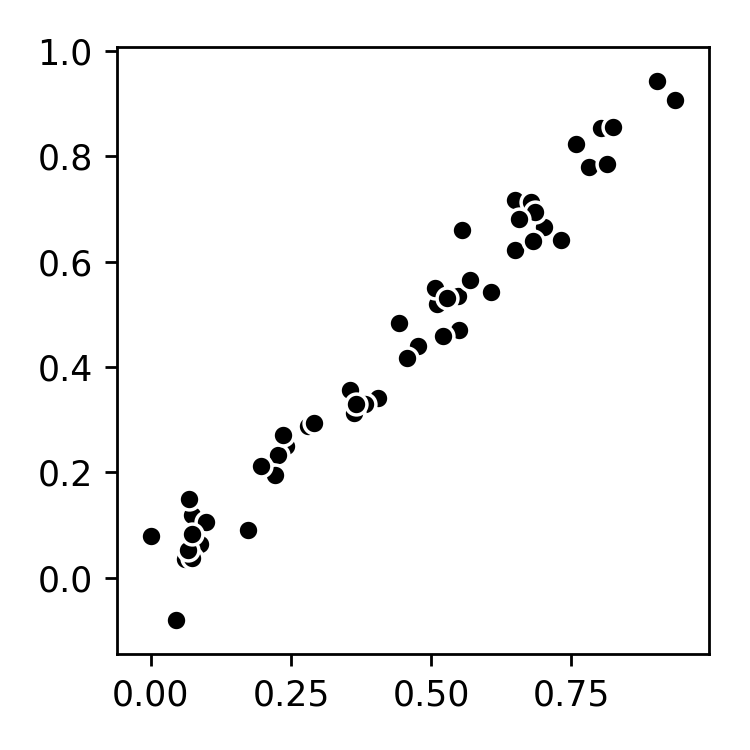

In [3]:
# load in data
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/2d_linregress_data.csv',delimiter=',')
x = data[:,:-1]
y = data[:,-1:]

# pack ones into x to simplify code
o = np.ones((len(y),1))
x = np.concatenate((o,x),axis = 1)

# scatter plot the input data
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(data[:,0],data[:,1],color = 'k',edgecolor = 'w')

Now lets run coordinate descent.

In [4]:
# run your alternating descent code
max_its = 15
w_history = coordinate_descent_for_LS(x,y,max_its)

With the run complete we plot the cost function decrease at each weight update.

<IPython.core.display.Javascript object>


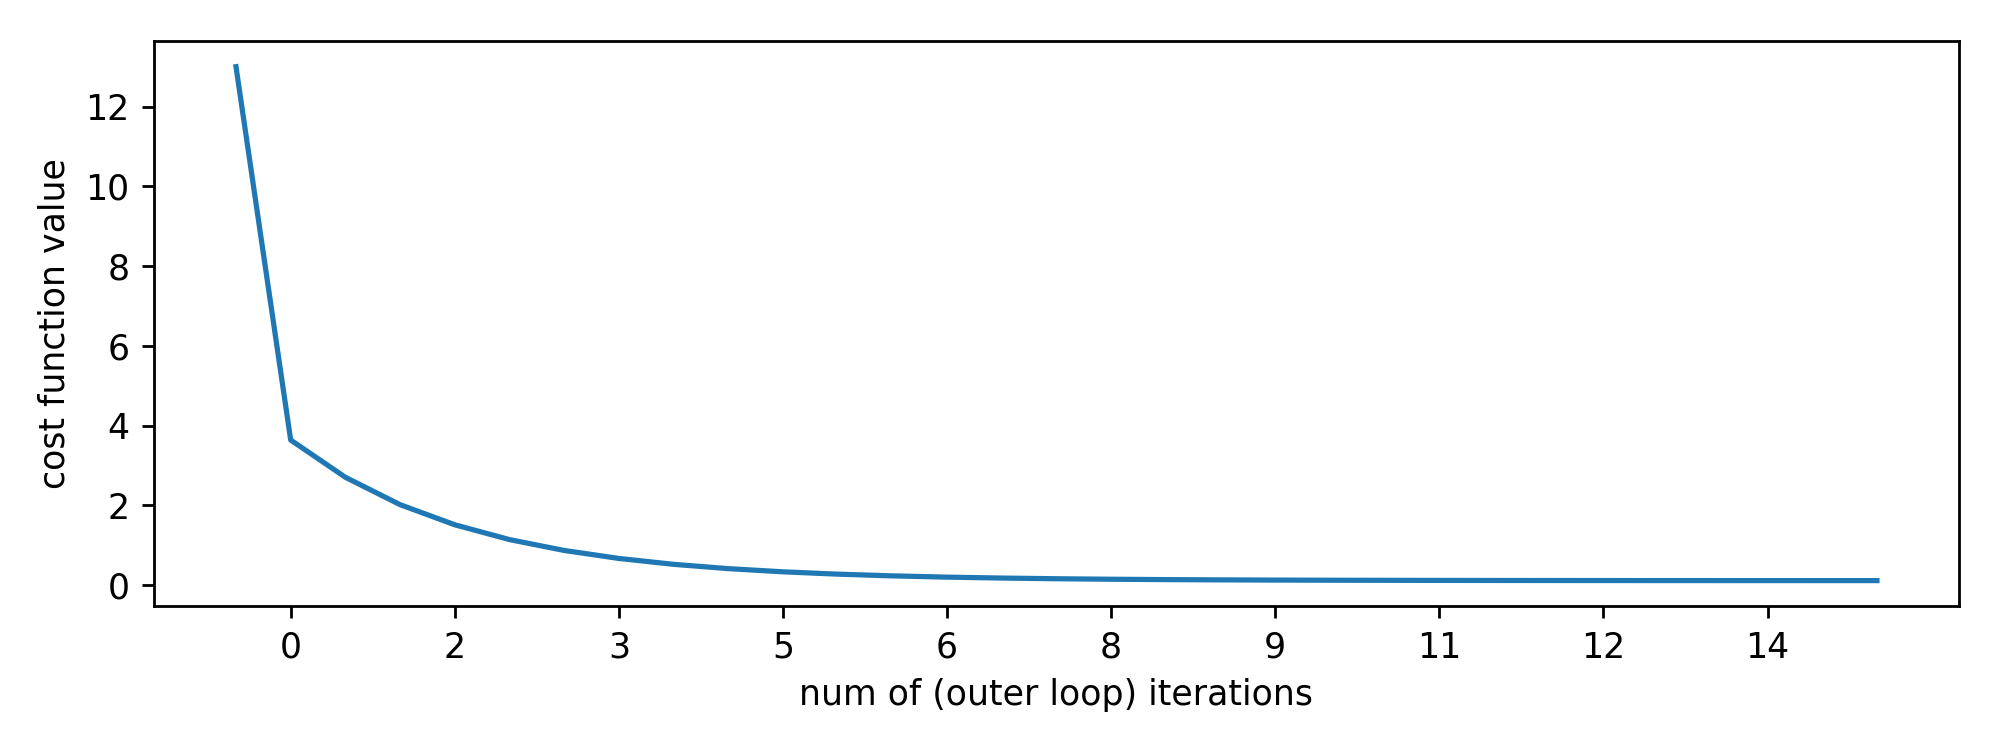

In [5]:
# draw the cost function decrease plot
g = lambda w: np.sum((np.dot(x,w) - y)**2)

# plot resulting cost function history based on w_history
demo = optlib.coord_descent_plotter.Visualizer();
demo.plot_coord_descent_cost_history(g,w_history)

Since there are only two weights we can visualize the descent path on the cost ontour - which we do in the next Python cell.

<IPython.core.display.Javascript object>


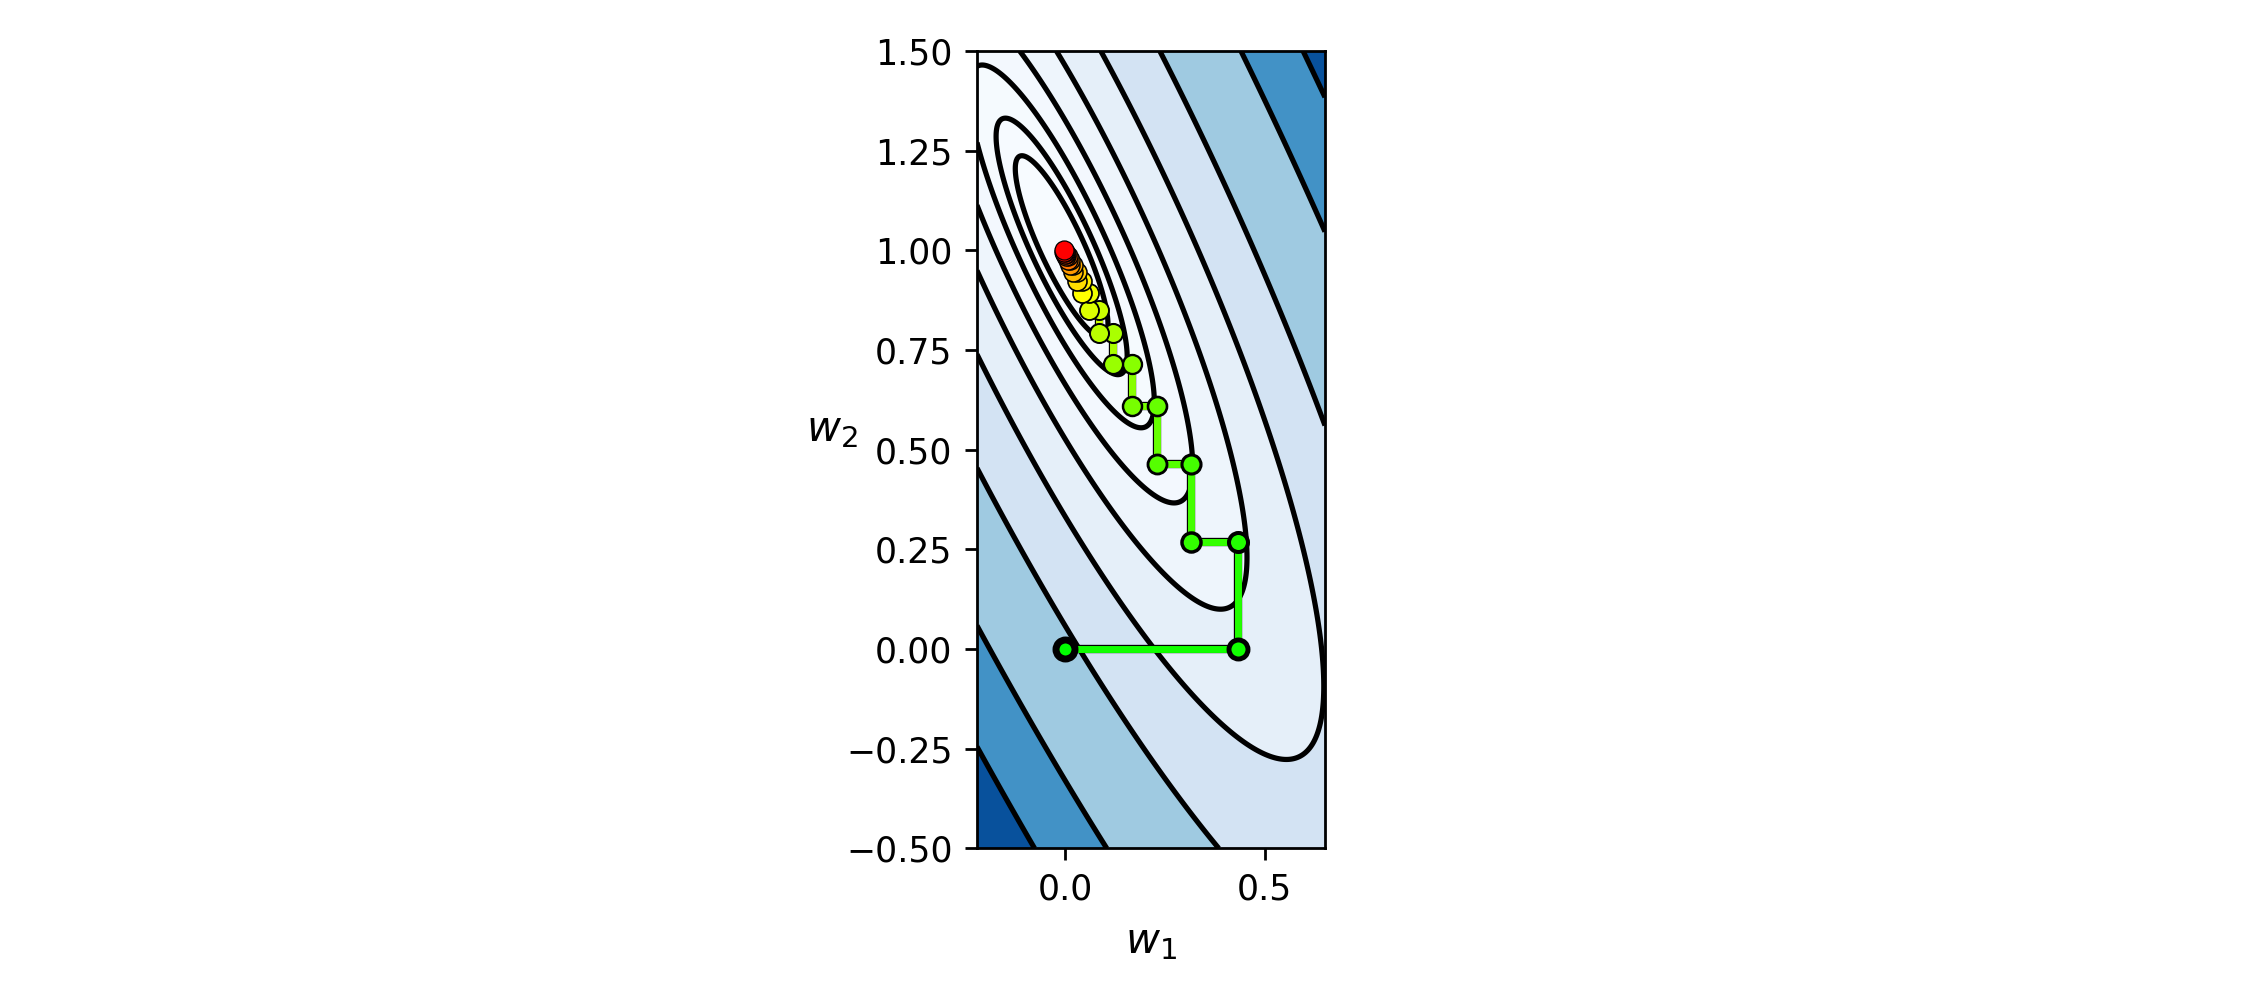

354.973638028


In [59]:
# plot the path taken by alternating descent by plotting each weight from your history
g = lambda w: np.sum((np.dot(x,w) - y)**2)

# plot the contours
demo.show_path(g,w_history,num_contours = 25)

Now let us visualize the fit provided by the final weights

<IPython.core.display.Javascript object>


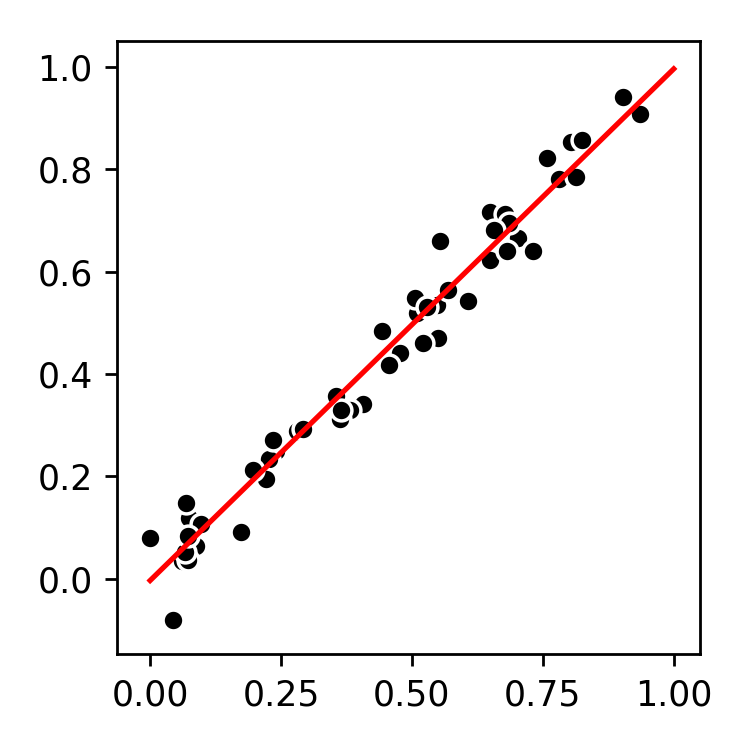

In [61]:
# our initial weights
w = w_history[-1]

# scatter plot the input data
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(data[:,0],data[:,1],color = 'k',edgecolor = 'w')

# fit a trend line
x_vals = np.linspace(0,1,200)
y_vals = [w[0] + w[1]*v for v in x_vals]
ax.plot(x_vals,y_vals,color = 'red')
plt.show()

The next Python cell loads in a dataset of 100 input/output pairs from a 10 dimensional dataset.  This dataset was constructed by randomly sampling a 10-dimensional hyperplane, so using linear regression we should be able to find a good linear fit to it.

In [63]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/highdim_linregress_data.csv',delimiter=',')

# form the input/output data vectors
x = data[:,:-1]
y = data[:,-1:]

# pack ones into x to simplify code
o = np.ones((len(y),1))
x = np.concatenate((o,x),axis = 1)

Running coordinate descent for 50 iterations leads to a point very close to the minimum.

In [64]:
# run your alternating descent code
max_its = 50
w_history = coordinate_descent_for_LS(x,y,max_its)

We can now plot the cost function value over each weight update.

<IPython.core.display.Javascript object>


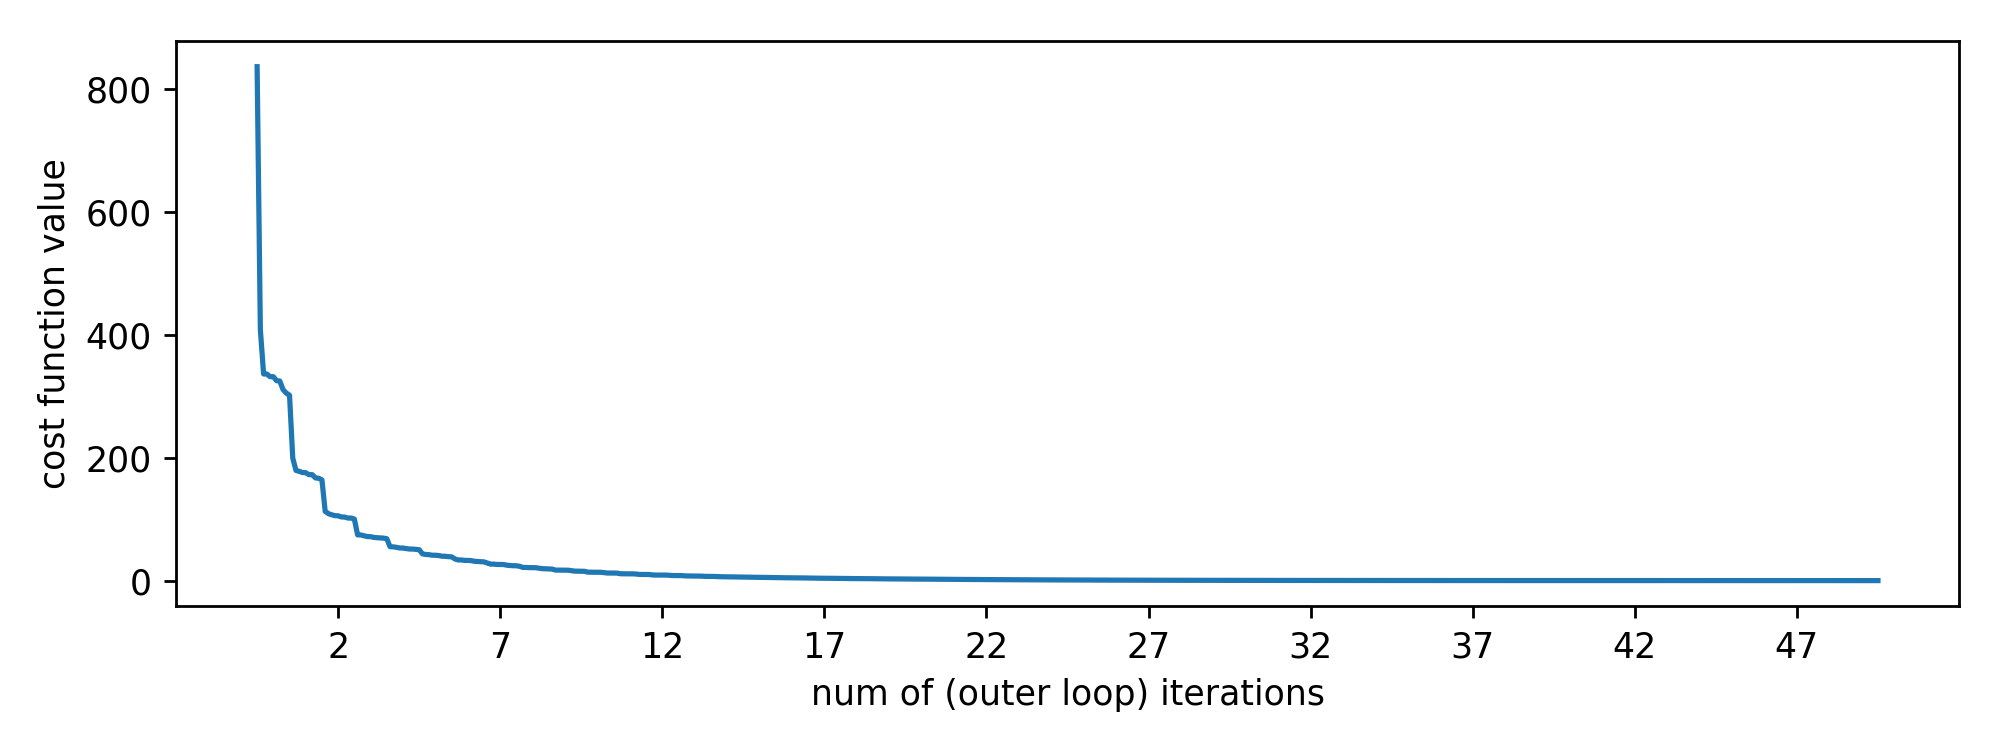

In [65]:
# Our compact least squares function
g = lambda w: np.sum((np.dot(x,w) - y)**2)

# plot resulting cost function history based on w_history
demo = optlib.coord_descent_plotter.Visualizer();
demo.plot_coord_descent_cost_history(g,w_history)

#### <span style="color:#a50e3e;">Example 4:</span>  Logistic regression

For a dataset of $P$ points $\left(\mathbf{x}_{1},y_{1}\right),\,\left(\mathbf{x}_{2},y_{2}\right),\,...,\,\left(\mathbf{x}_{P},y_{P}\right)$ we re-annotate using the compact notation

\begin{equation}
\mathbf{w} \longleftarrow \left[\begin{array}{c}
w_{0}\\
\mathbf{w}
\end{array}\right]
\,\,\,\,\text{and}\,\,\,\,\,
\mathbf{x}_{p}\longleftarrow\left[\begin{array}{c}
1\\
\mathbf{x}_{p}.
\end{array}\right]
\end{equation}

in order to write out the Least Squares cost without an explicit bias as

\begin{equation}
\,g\left(\mathbf{w}\right)=\sum_{p=1}^{P}\text{log}\left(1 + e^{-y_{p}\mathbf{x}_{p}^{T}\mathbf{w} } \right).
\end{equation}

Computing the partial derivative of the above in the $n^{th}$ weight alone we have

\begin{equation}
\frac{\partial}{\partial w_n} g =  -\sum_{p=1}^{P} \frac{  e^{-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}}  }{1 + e^{-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}}   }x_{p,n}y_p
\end{equation}

Equivalently multiplying each summand by $1 = \frac{e^{-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}} }{  e^{-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}}   }$ the above can be written equivalently as 

\begin{equation}
\frac{\partial}{\partial w_n} g =  -\sum_{p=1}^{P} \frac{ 1 }{1 + e^{y_{p}\mathbf{x}_{p}^{T}\mathbf{w}}   }x_{p,n}y_p
\end{equation}

The second partial in $w_n$ can then be computed as 

\begin{equation}
\frac{\partial}{\partial w_n} g =  \sum_{p=1}^{P} \frac{ e^{y_{p}\mathbf{x}_{p}^{T}\mathbf{w}^{\,}}  }{\left( 1 + e^{y_{p}\mathbf{x}_{p}^{T}\mathbf{w}}\right)^2   }x_{p,n}^2
\end{equation}

Using the standard derivative rules we can then compute both the first and second partial derivatives in $w_n$, and write the Newton step in $w_n$ as

\begin{equation}
w_n^{\,} = w_n^{\text{old}} - \frac{ -\sum_{p=1}^{P} \frac{ 1 }{1 + e^{y_{p}\mathbf{x}_{p}^{T}\mathbf{w}^{\text{old}}}   }x_{p,n}y_p         }{   \sum_{p=1}^{P} \frac{ e^{y_{p}\mathbf{x}_{p}^{T}\mathbf{w}^{\text{old}}}  }{\left( 1 + e^{y_{p}\mathbf{x}_{p}^{T}\mathbf{w}^{\text{old}}}\right)^2   }x_{p,n}^2 }.
\end{equation}

We provide an implementation of coordinate descent for logistic regression in the next Python cell.  In this implementation we take just a single Newton step in each input direction when updating.

In [2]:
def coordinate_descent_for_logistic(x,y,max_its):
    '''
    Coordinate descent for Least Squares
    X - the Px(N+1) data matrix
    y - the Px1 output vector
    '''

    # cost function for tol checking
    g = lambda w: np.sum(np.log(1 + np.exp(-y*np.dot(x,w))))

    # settings 
    its = max_its                      # max its to run
    tol = 10**(-8)                     # tolerance to between sweeps to stop (optional)
    N = np.shape(x)[1]                 # length of weights
    w = np.zeros((N,1))                # initialization
    w_history = [copy.deepcopy(w)]     # record each weight for plotting
    
    # outer loop - each is a sweep through every variable once
    i = 0
    g_change = np.inf; gval1 = g(w);
    while i < its and g_change > tol:
        ### inner loop - each is a single variable update       
        # update weights
        for n in range(N): 
            # compute numerator of newton update
            temp1 = x[:,n:n+1]*y
            temp2 = y*np.dot(x,w)  
            temp2 = [np.exp(v) for v in temp2]
            numer = -np.sum(np.asarray([v/(1 + r) for v,r in zip(temp1,temp2)]))
            
            # compute denominator
            temp3 = [v/(1 + v)**2 for v in temp2]
            temp4 = x[:,n:n+1]**2
            denom = np.sum(np.asarray([v*r for v,r in zip(temp3,temp4)]))
            
            # take newton step
            w[n] -= numer/denom
            
            # record weights at each step for kicks
            w_history.append(copy.deepcopy(w))
            
        # update counter and tol measure
        gval2 = copy.deepcopy(gval1)
        gval1 = g(w)
        g_change = abs(gval1 - gval2)/float(np.size(w))
        i+=1
    return w_history

We can test out our algorithm on an $N= 2$ dimensional input example, so that we may also examine the descent path plotted on the contour map of the cost function.

<IPython.core.display.Javascript object>


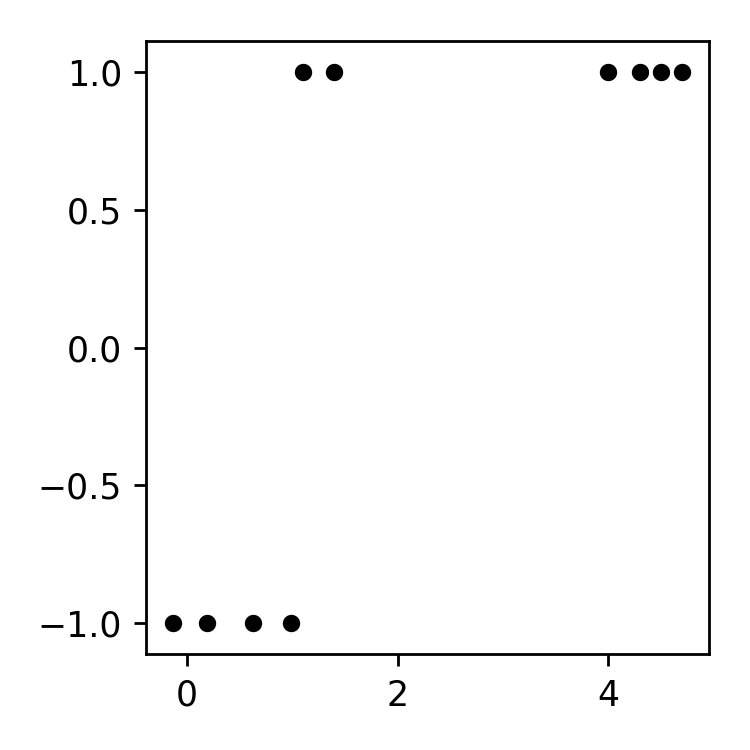

In [3]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/2d_classification_data_v1.csv')
x = data[:,:-1:]
y = data[:,-1:]

# pack ones into x to simplify code
o = np.ones((len(y),1))
x = np.concatenate((o,x),axis = 1)

# scatter plot the input data
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(data[:,0],data[:,1],color = 'k',edgecolor = 'w')

In the next Python cells we run coordinate descent, plot the cost function decrease plot over the run, plot the resulting descent run on the contour plot of the softmax function, and plot the fit resulting from the final weight of the run on the data itself..

In [81]:
# run your alternating descent code
max_its = 50
w_history = coordinate_descent_for_logistic(x,y,max_its)

<IPython.core.display.Javascript object>


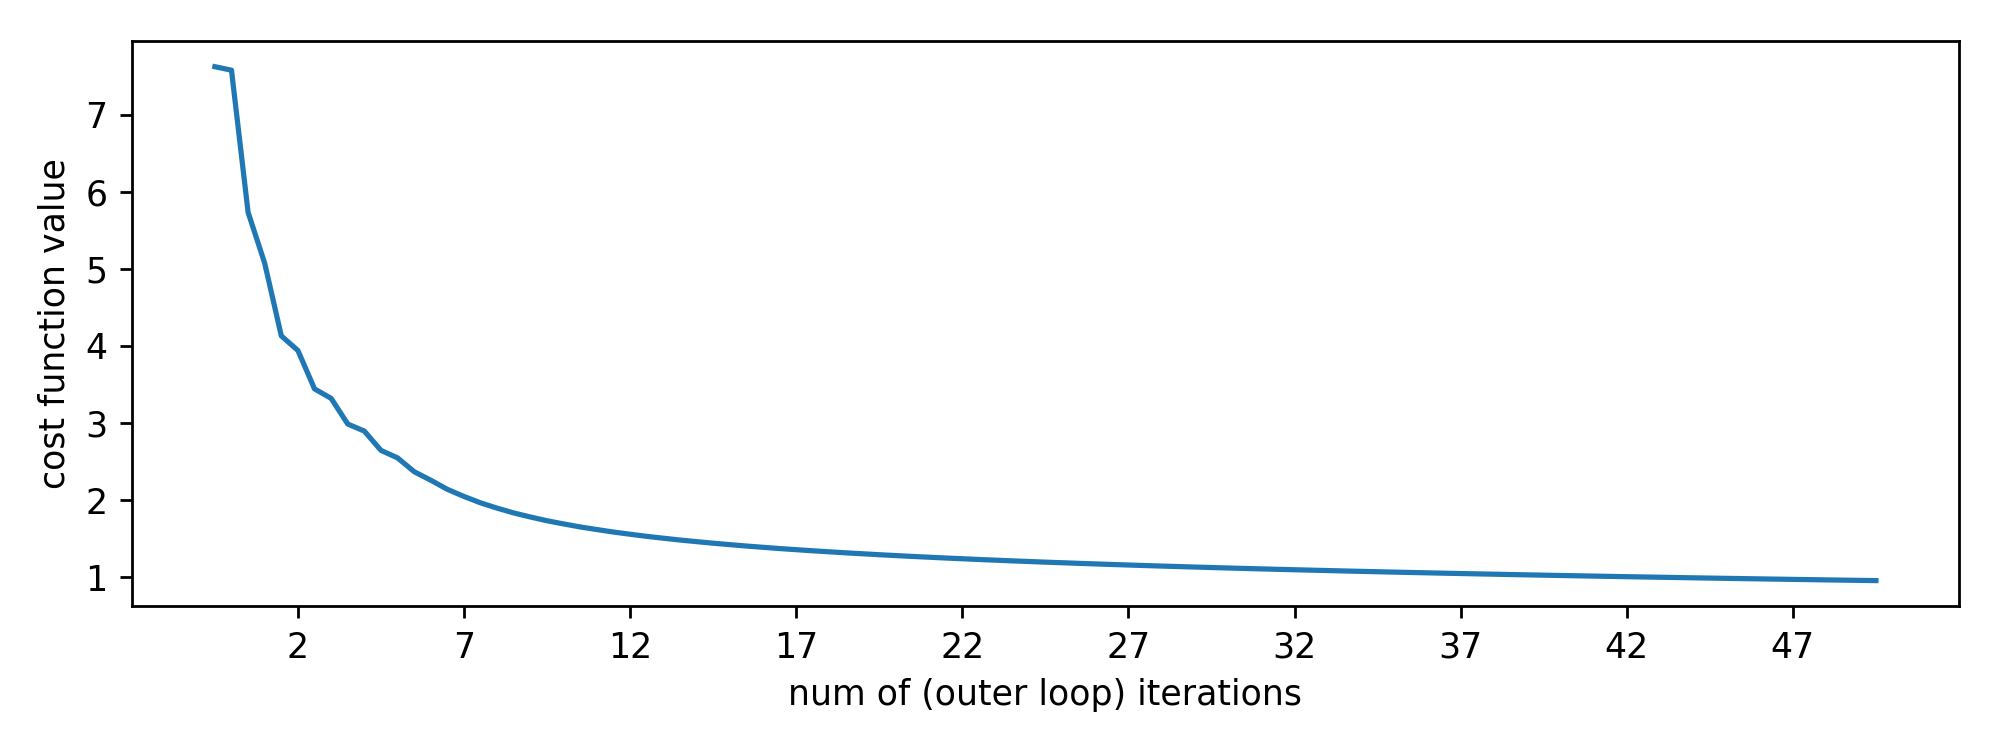

In [82]:
# Our compact least squares function
g = lambda w: np.sum(np.log(1 + np.exp(-y*np.dot(x,w))))

# plot resulting cost function history based on w_history
demo = optlib.coord_descent_plotter.Visualizer();
demo.plot_coord_descent_cost_history(g,w_history)

<IPython.core.display.Javascript object>


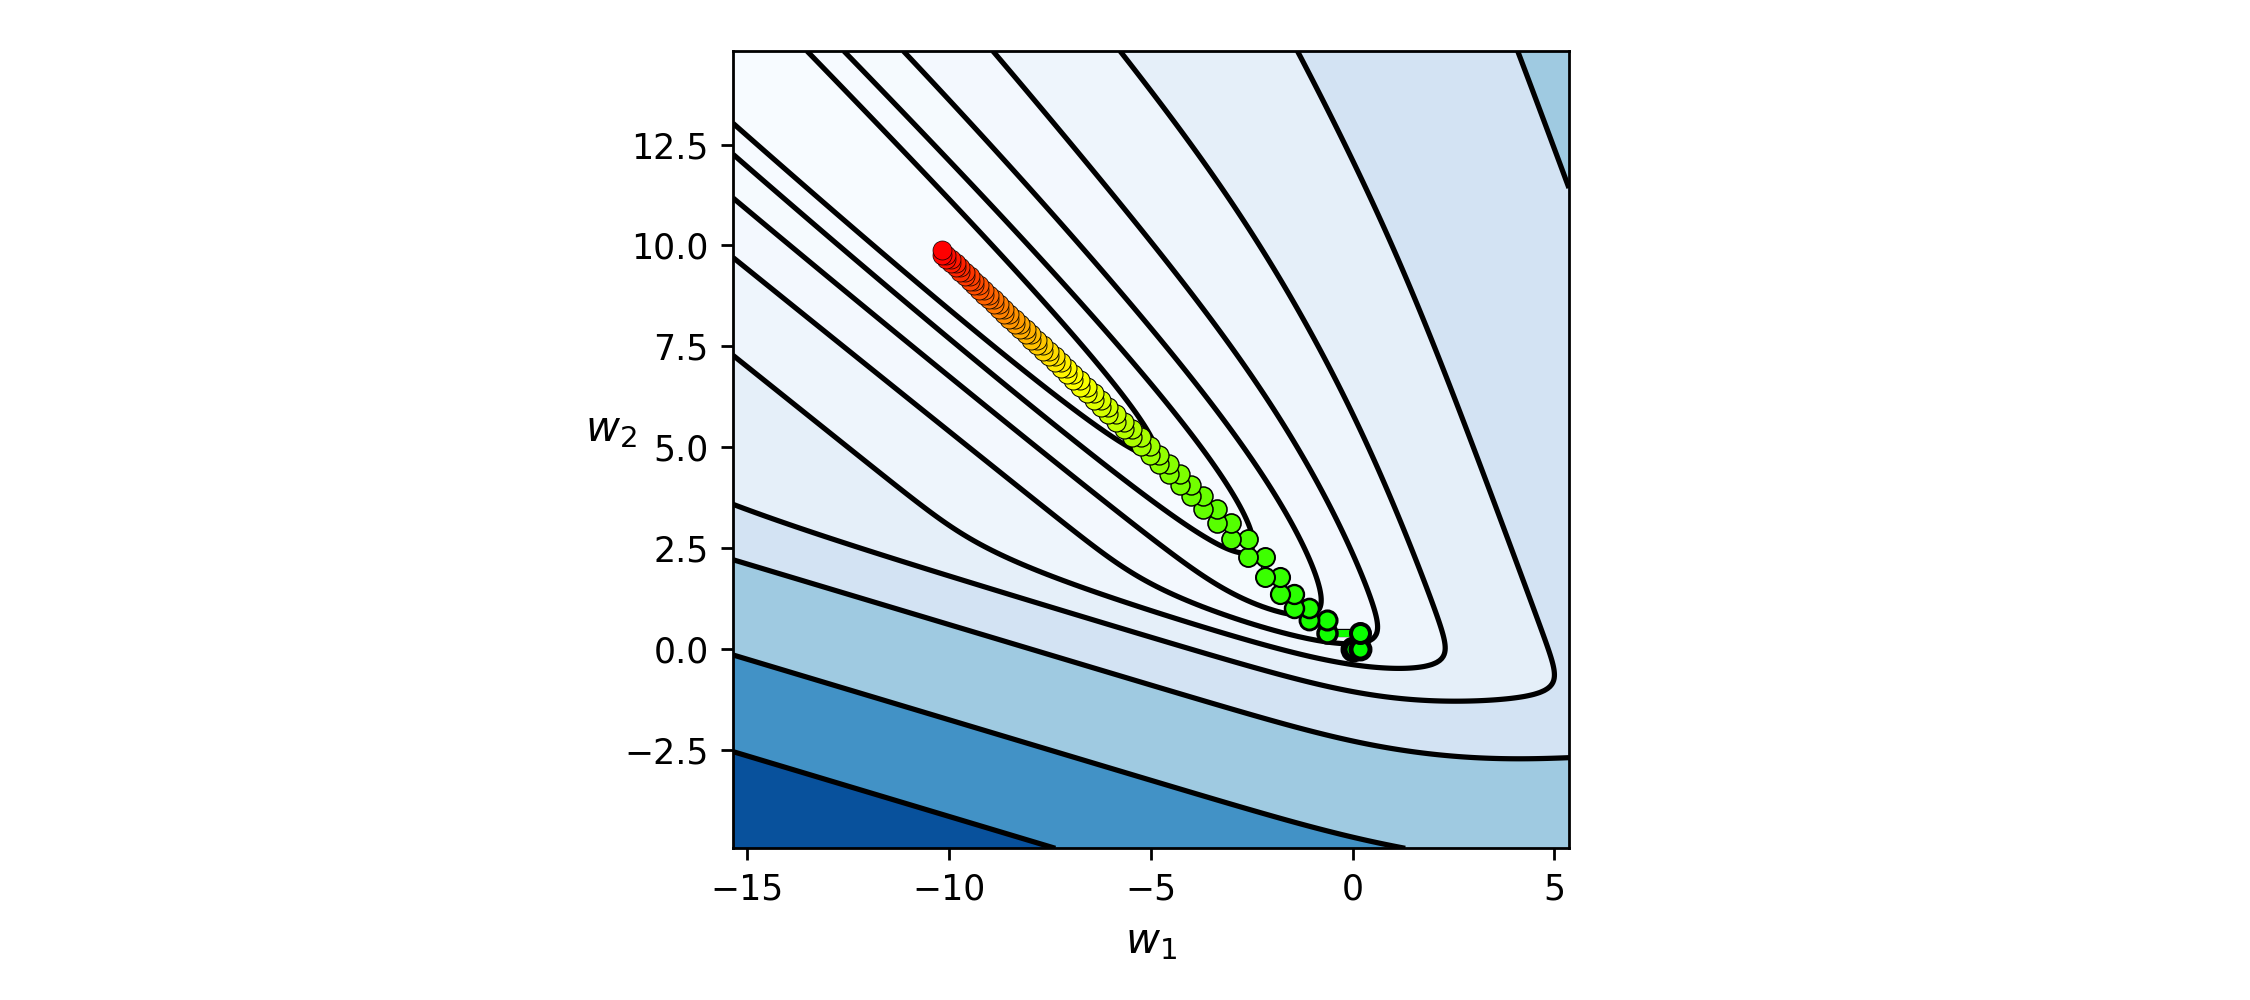

In [83]:
# plot the path taken by alternating descent by plotting each weight from your history
g = lambda w: np.sum(np.log(1 + np.exp(-y*np.dot(x,w))))

# plot the contours
demo.show_path(g,w_history,num_contours = 25)

<IPython.core.display.Javascript object>


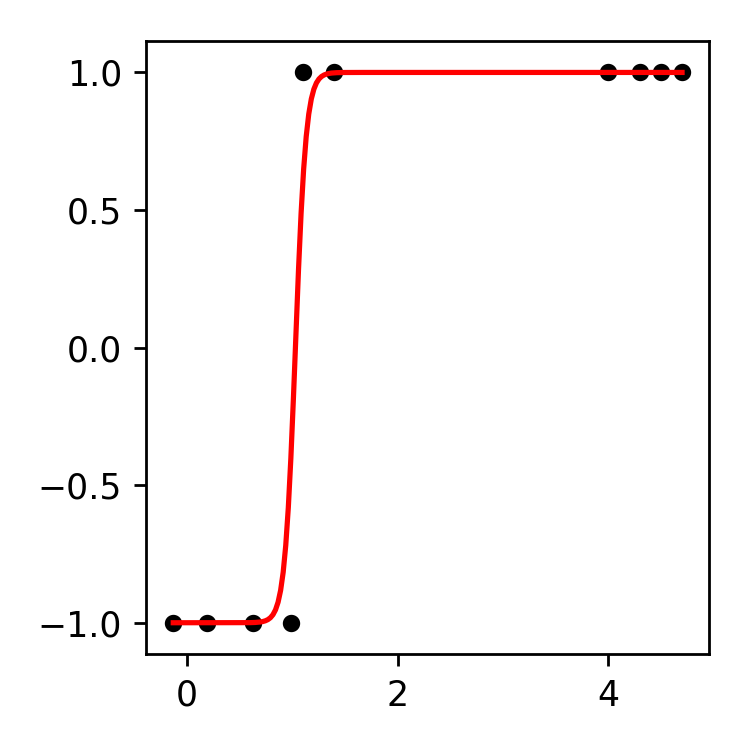

In [86]:
# our initial weights
w = w_history[-1]

# scatter plot the input data
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(data[:,0],data[:,1],color = 'k',edgecolor = 'w')

# fit a trend line
x_vals = np.linspace(min(data[:,0]),max(data[:,0]),200)
y_vals = [np.tanh(w[0] + w[1]*v) for v in x_vals]
ax.plot(x_vals,y_vals,color = 'red')
plt.show()

<IPython.core.display.Javascript object>


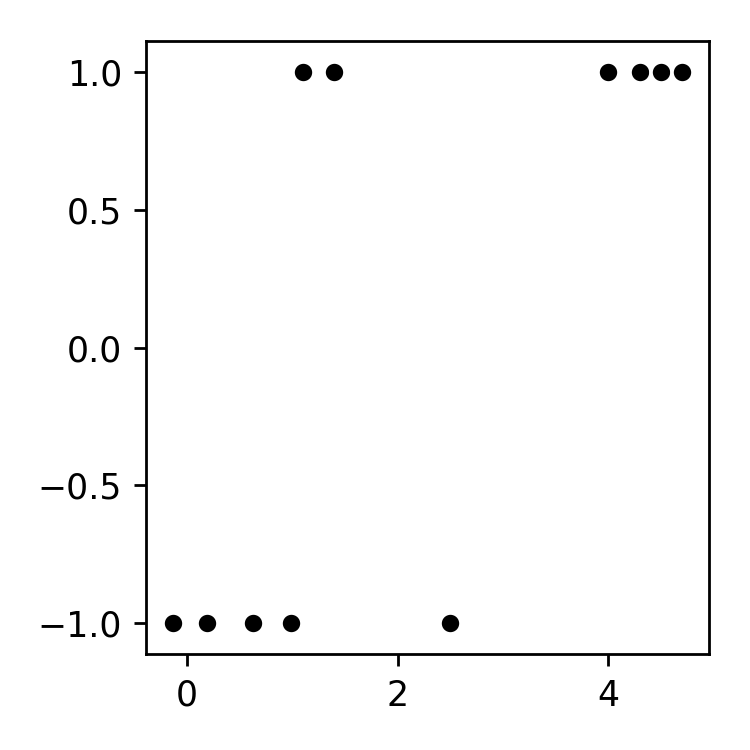

In [3]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/2d_classification_data_v2.csv')
x = data[:,:-1:]
y = data[:,-1:]

# pack ones into x to simplify code
o = np.ones((len(y),1))
x = np.concatenate((o,x),axis = 1)

# scatter plot the input data
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(data[:,0],data[:,1],color = 'k',edgecolor = 'w')

<IPython.core.display.Javascript object>


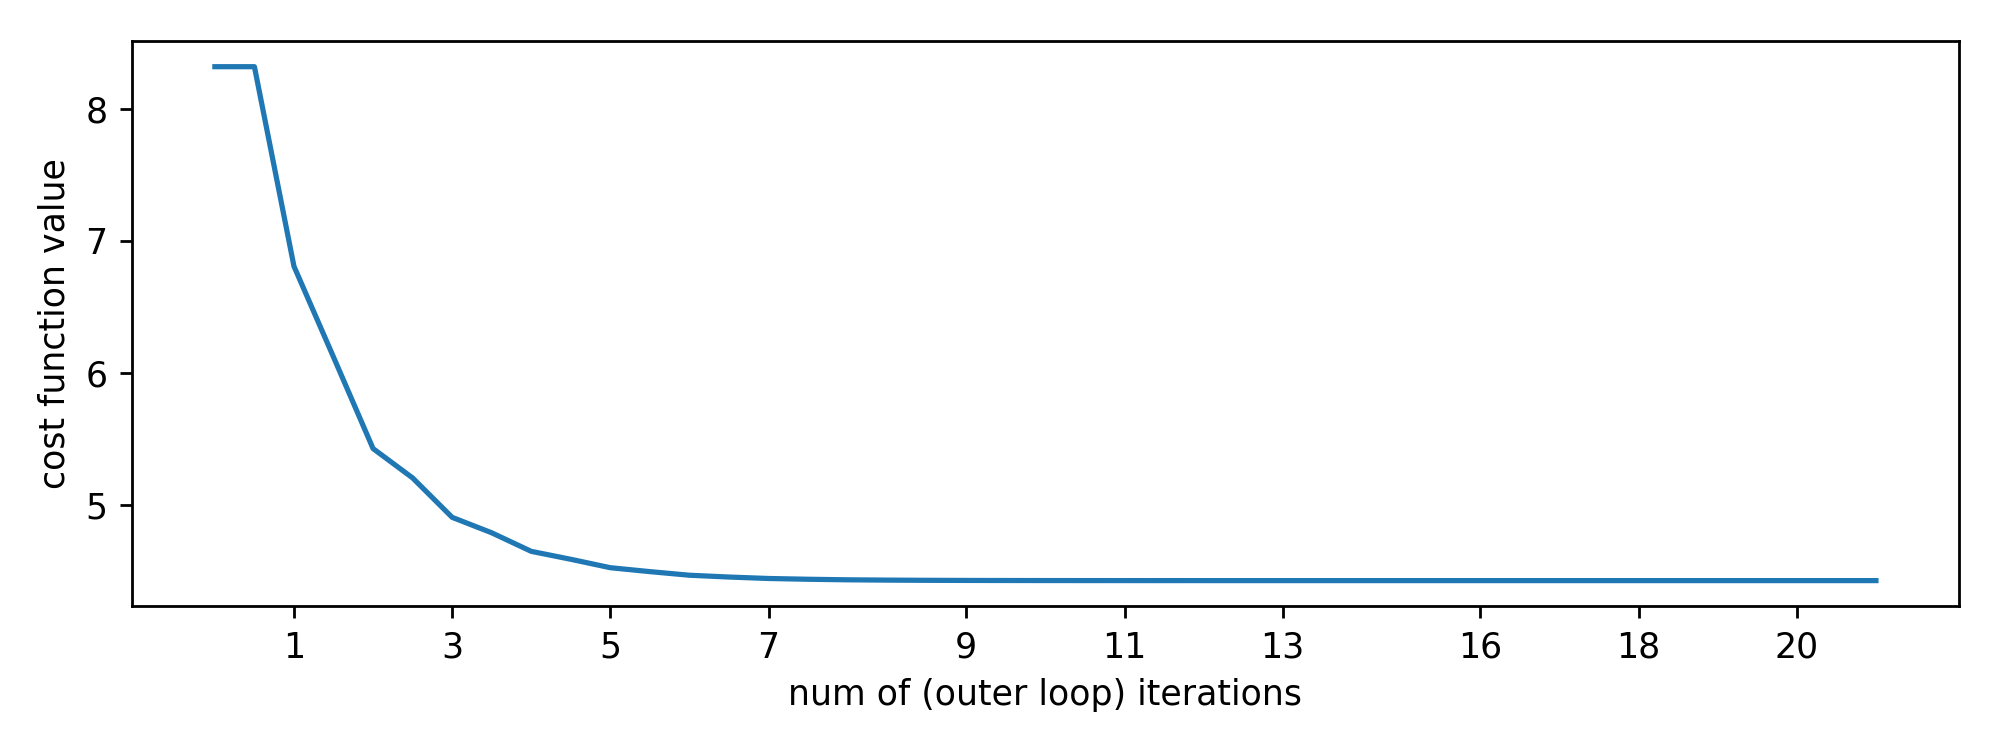

<IPython.core.display.Javascript object>


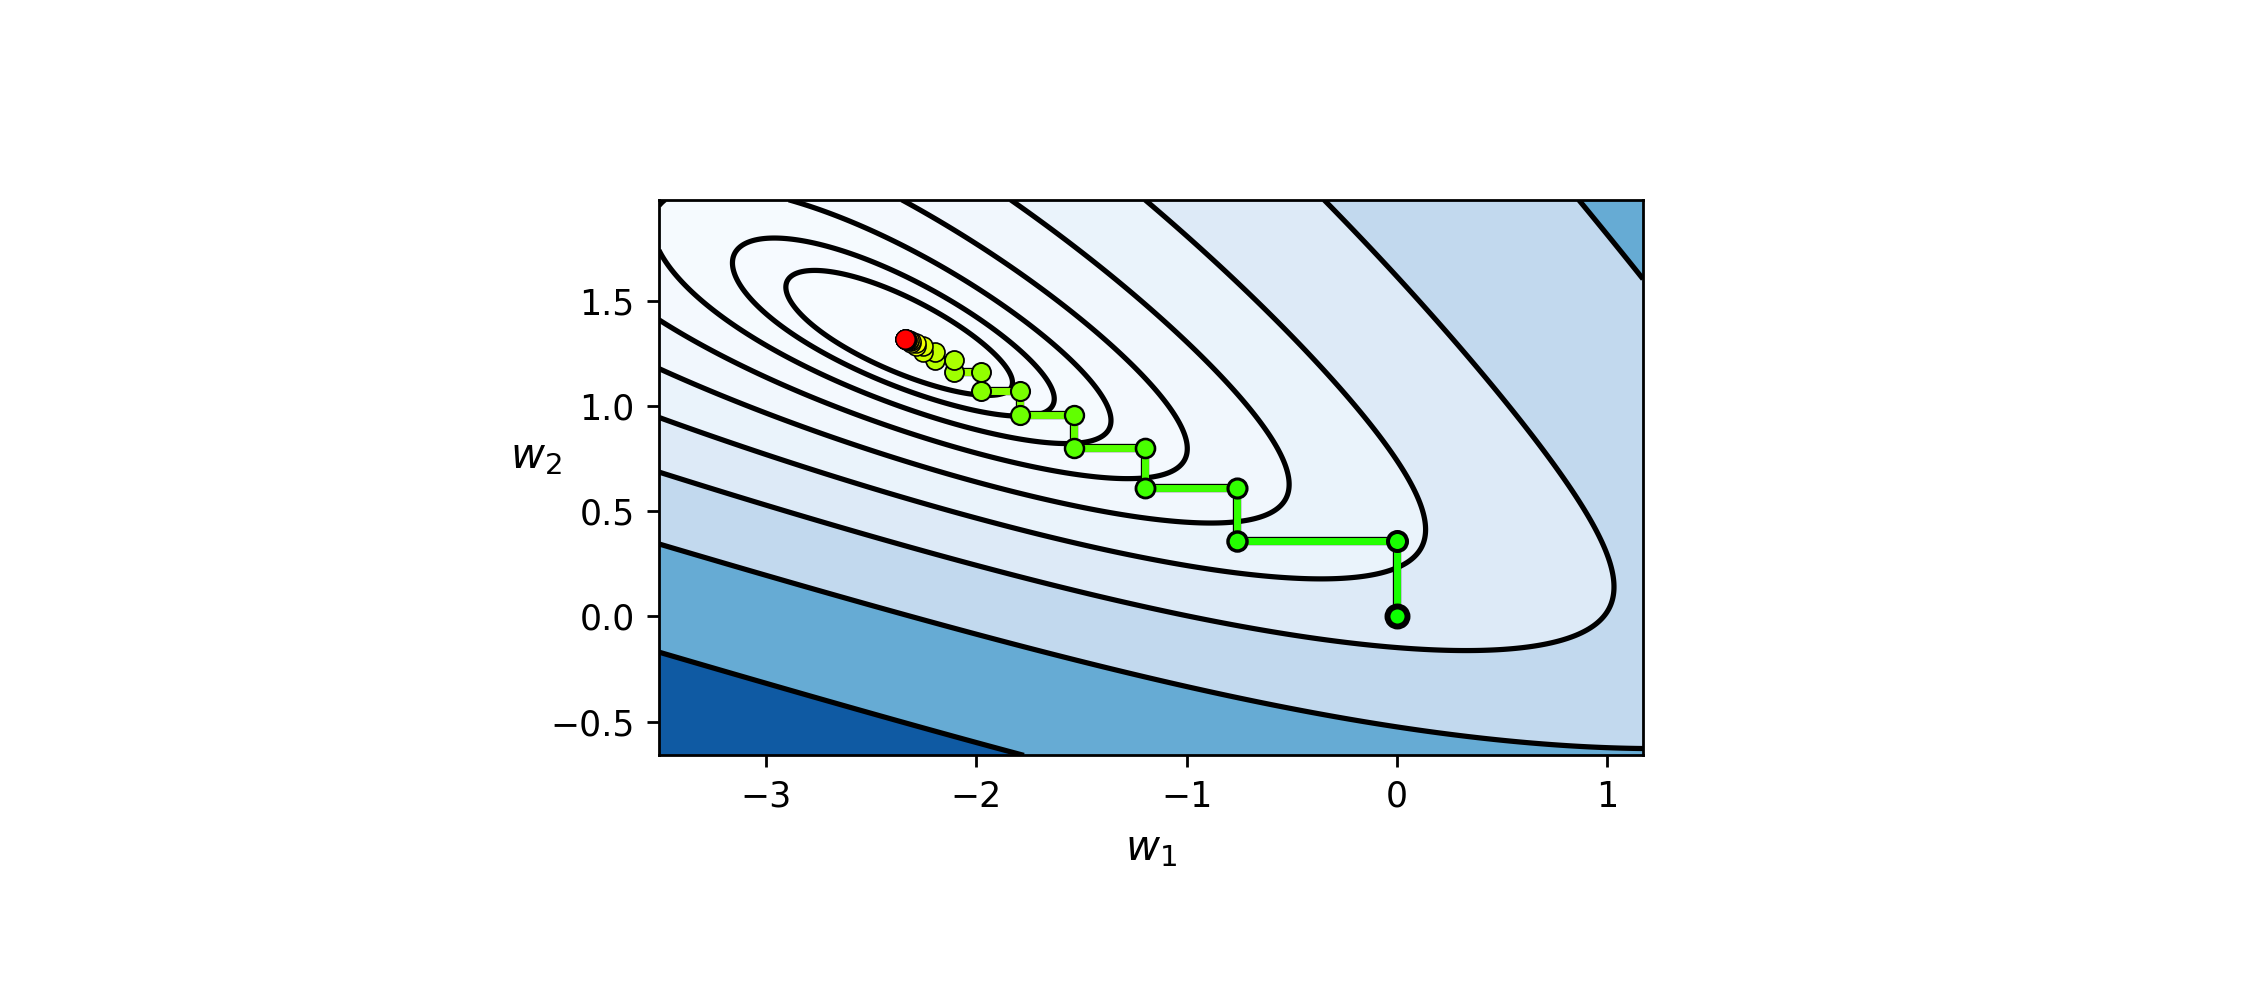

<IPython.core.display.Javascript object>


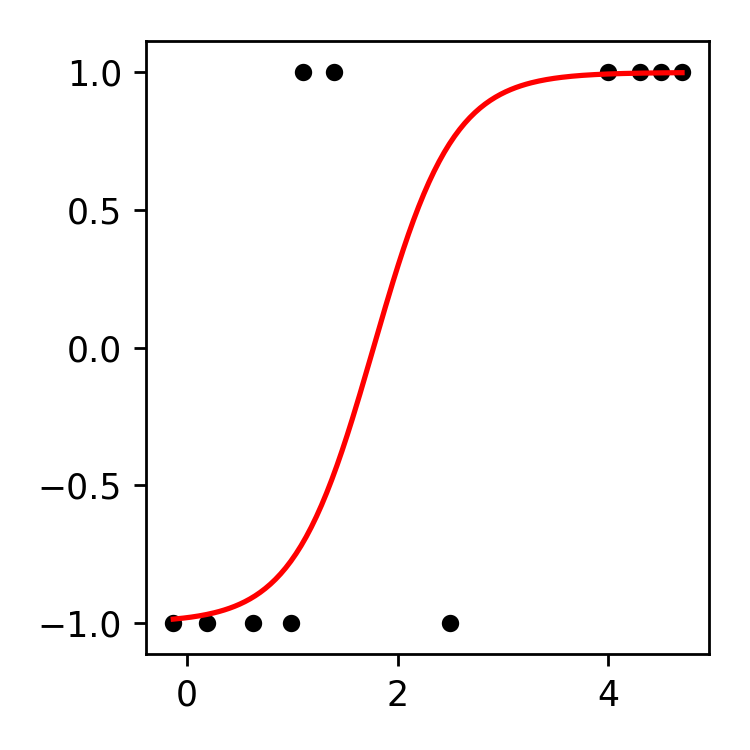

In [5]:
# run your alternating descent code
max_its = 30
w_history = coordinate_descent_for_logistic(x,y,max_its)

# Our compact least squares function
g = lambda w: np.sum(np.log(1 + np.exp(-y*np.dot(x,w))))

# plot resulting cost function history based on w_history
demo = optlib.coord_descent_plotter.Visualizer();
demo.plot_coord_descent_cost_history(g,w_history)

# plot the path taken by alternating descent by plotting each weight from your history
g = lambda w: np.sum(np.log(1 + np.exp(-y*np.dot(x,w))))

# plot the contours
demo.show_path(g,w_history,num_contours = 25)

# our initial weights
w = w_history[-1]

# scatter plot the input data
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(data[:,0],data[:,1],color = 'k',edgecolor = 'w')

# fit a trend line
x_vals = np.linspace(min(data[:,0]),max(data[:,0]),200)
y_vals = [np.tanh(w[0] + w[1]*v) for v in x_vals]
ax.plot(x_vals,y_vals,color = 'red')
plt.show()